# MultiModal RAG with ColQwen2 and Llama 3.2 90B Vision
## PDF Chatbots with a Twist!

## Hardware Requirements
*To ensure the notebook runs faster please change the runtime type to T4 GPU:
`Runtime` -> `Change runtime type` -> `T4 GPU`*

*You can also run this notebook on a 16Gb M1 Macbook Pro

## Introduction

In this notebook we will see how to use Multimodal RAG to chat with Nvidia's invester slide deck from last year. The [slide deck](https://s201.q4cdn.com/141608511/files/doc_presentations/2023/Oct/01/ndr_presentation_oct_2023_final.pdf) is 39 pages with a combination of text, visuals, tables, charts and annotations. The document structure and templates vary from page to page and is quite difficult to RAG over using traditional methods.

We will be using a new multimodal approach!

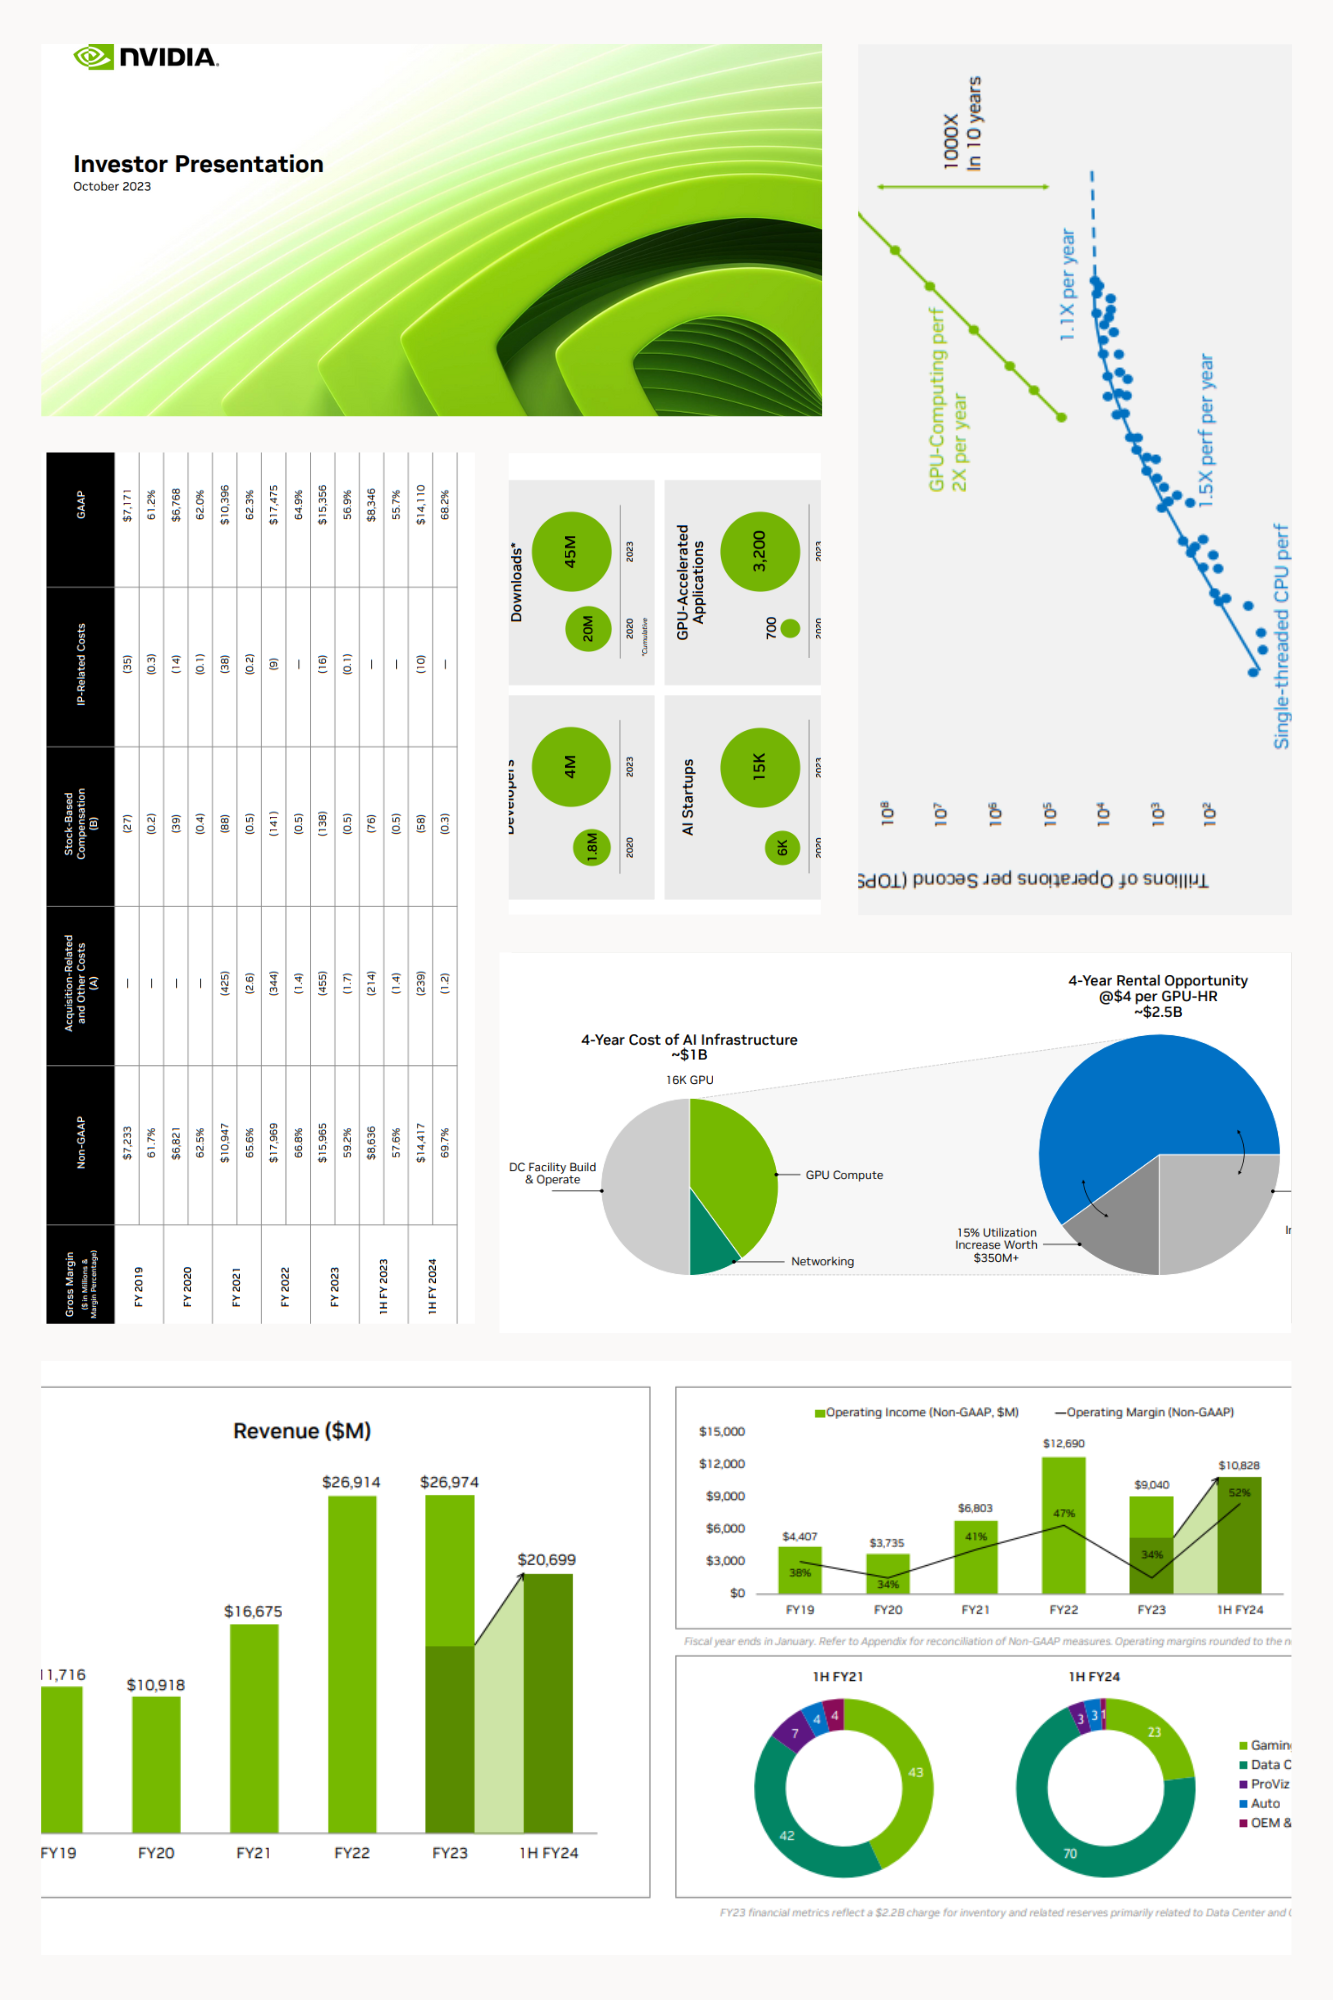

## MultiModal RAG Workflow

[ColPali](https://arxiv.org/abs/2407.01449) is a new multimodal retrieval system that seamlessly enables image retrieval.

By directly encoding image patches, it eliminates the need for optical character recognition (OCR), or image captioning to extract text from PDFs.

We will use `byaldi`, a library from [AnswerAI](https://www.answer.ai/), that makes it easier to work with an upgraded version of ColPali, called ColQwen2, to embed and retrieve images of our PDF documents.

Retrieved pages will then be passed into the Llama-3.2 90B Vision model served via a [Together AI](https://www.together.ai/) inference endpoint for it to answer questions.

To get a better explanation of how ColPali and the new Llama 3.2 Vision models work checkout the [blog post](link_to_blogpost) connected for this notebook.

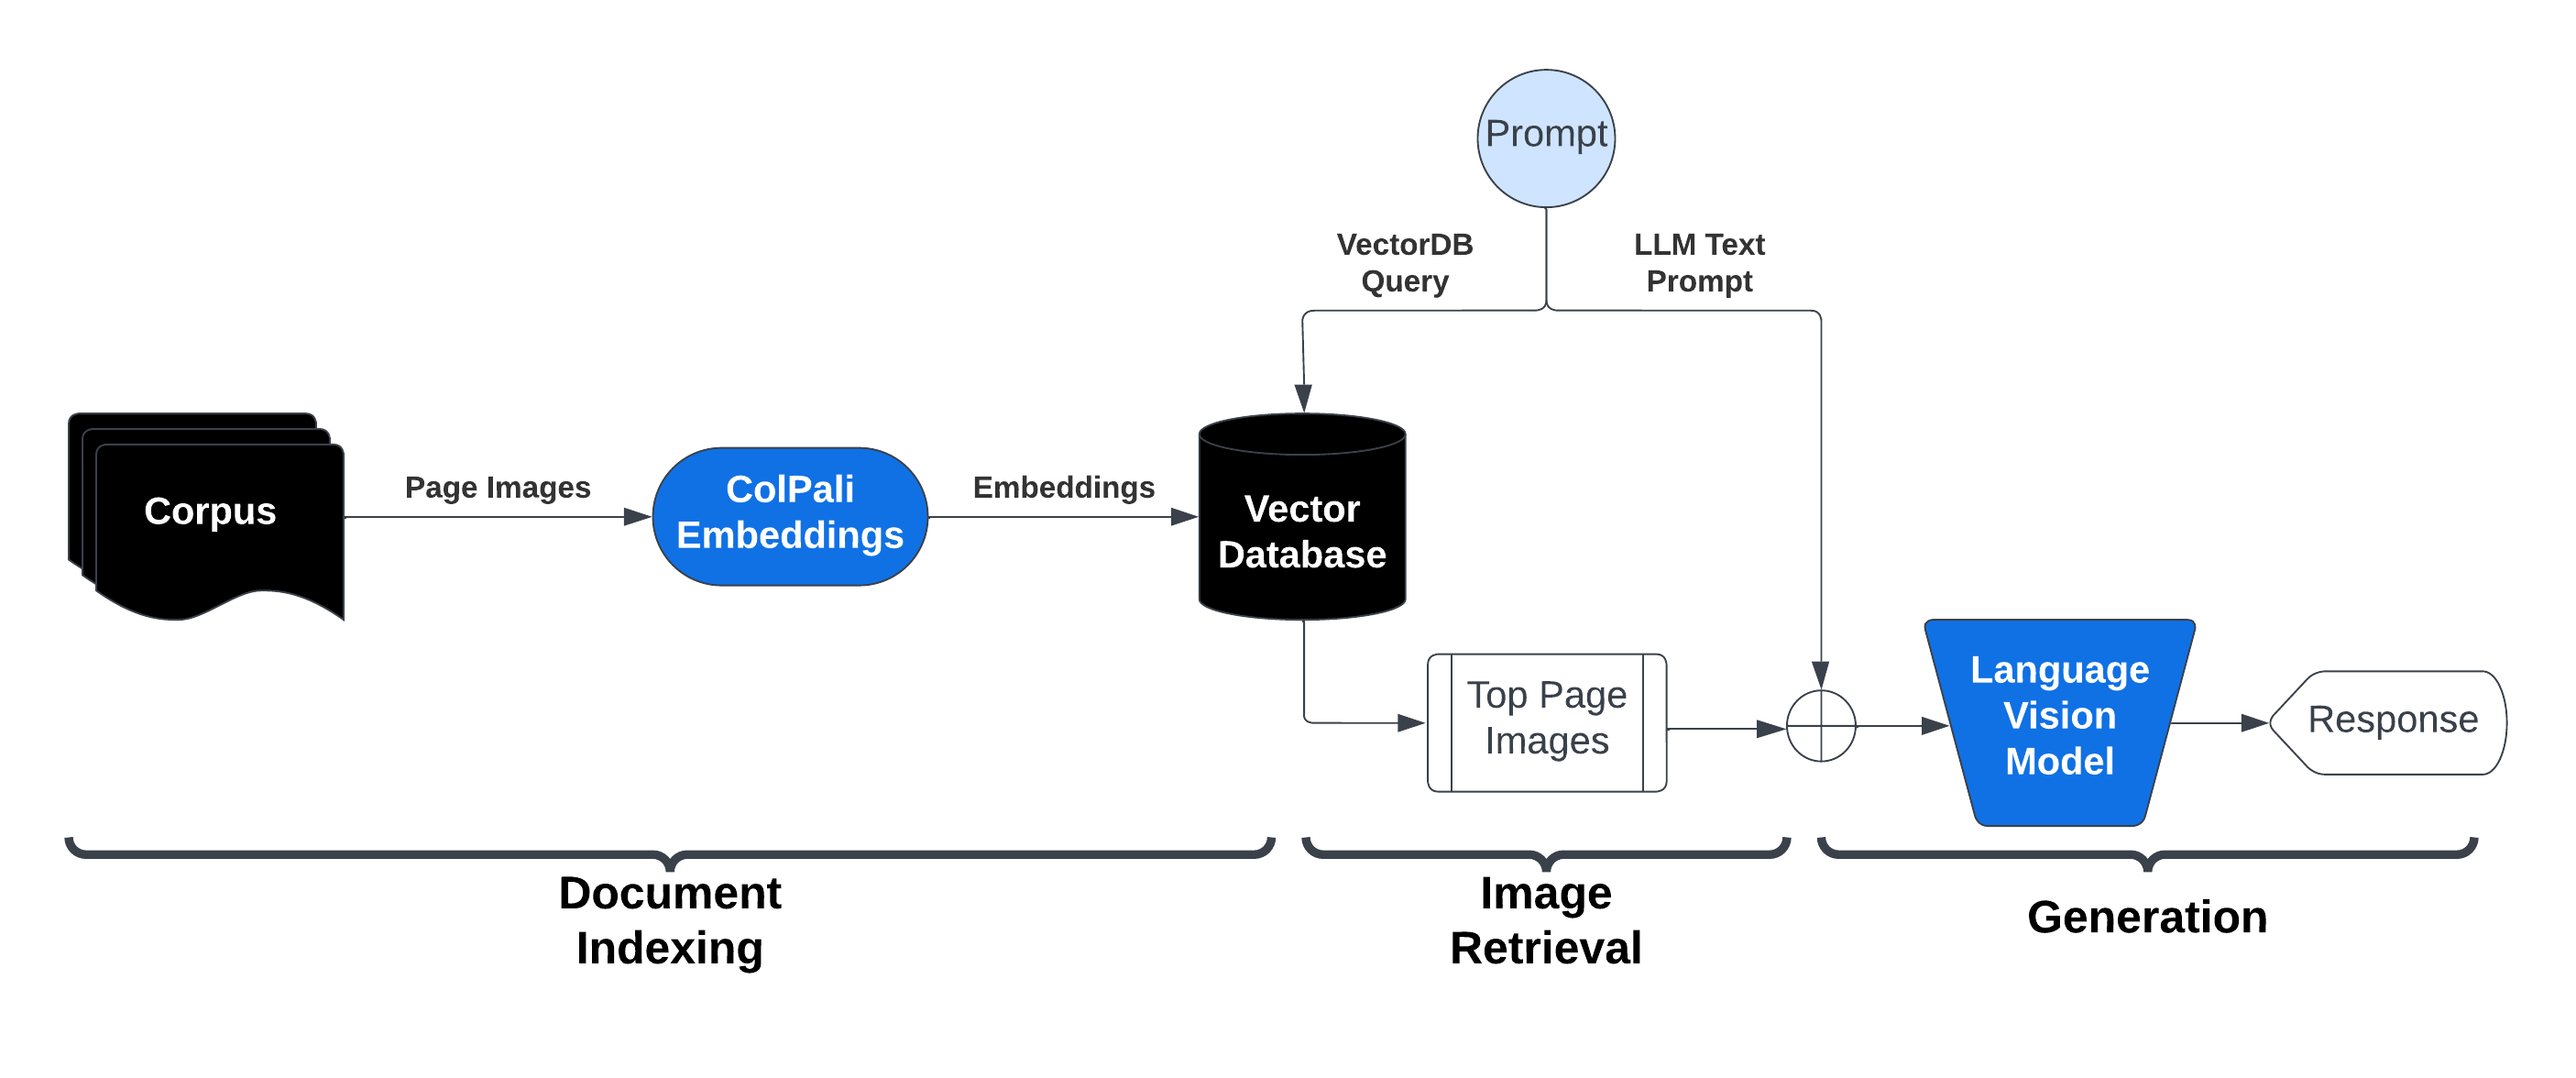

### Install relevant libraries

In [1]:
!pip install byaldi together pdf2image

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.9/517.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━

In [2]:
#Paste in your Together AI API Key or load it
api_key = os.environ.get("TOGETHER_API_KEY") #API key goes here

In [3]:
!sudo apt-get install -y poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.5 [186 kB]
Fetched 186 kB in 1s (186 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 123620 

### Initialize the ColPali Model

In [4]:
import os
from pathlib import Path
from byaldi import RAGMultiModalModel

# Initialize RAGMultiModalModel
model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v0.1")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}


model.safetensors.index.json:   0%|          | 0.00/56.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/74.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

### The document we will be retrieving from is a 39 page Nvidia investor presentation from 2023: [Investor Presentation October 2023](https://s201.q4cdn.com/141608511/files/doc_presentations/2023/Oct/01/ndr_presentation_oct_2023_final.pdf)

In [5]:
# Dowload and rename the last presentation from Nvidia to investors
!wget https://s201.q4cdn.com/141608511/files/doc_presentations/2023/Oct/01/ndr_presentation_oct_2023_final.pdf
!mv ndr_presentation_oct_2023_final.pdf nvidia_presentation.pdf

--2024-10-04 14:34:23--  https://s201.q4cdn.com/141608511/files/doc_presentations/2023/Oct/01/ndr_presentation_oct_2023_final.pdf
Resolving s201.q4cdn.com (s201.q4cdn.com)... 68.70.205.3, 68.70.205.4, 68.70.205.1, ...
Connecting to s201.q4cdn.com (s201.q4cdn.com)|68.70.205.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8609256 (8.2M) [application/pdf]
Saving to: ‘ndr_presentation_oct_2023_final.pdf’

ndr_presentation_oc 100%[===================>]   8.21M  24.4MB/s    in 0.3s    

2024-10-04 14:34:24 (24.4 MB/s) - ‘ndr_presentation_oct_2023_final.pdf’ saved [8609256/8609256]



### Lets create our index that will store the embeddings for the page images.

Caution: This cell below takes ~5 mins to index the whole PDF!

In [6]:
# Use ColQwen2 to index and store the presentation
index_name = "nvidia_index"
model.index(input_path=Path("/content/nvidia_presentation.pdf"),
    index_name=index_name,
    store_collection_with_index=True, #stores base64 images along with the vectors
    overwrite=True
)

Added page 1 of document 0 to index.
Added page 2 of document 0 to index.
Added page 3 of document 0 to index.
Added page 4 of document 0 to index.
Added page 5 of document 0 to index.
Added page 6 of document 0 to index.
Added page 7 of document 0 to index.
Added page 8 of document 0 to index.
Added page 9 of document 0 to index.
Added page 10 of document 0 to index.
Added page 11 of document 0 to index.
Added page 12 of document 0 to index.
Added page 13 of document 0 to index.
Added page 14 of document 0 to index.
Added page 15 of document 0 to index.
Added page 16 of document 0 to index.
Added page 17 of document 0 to index.
Added page 18 of document 0 to index.
Added page 19 of document 0 to index.
Added page 20 of document 0 to index.
Added page 21 of document 0 to index.
Added page 22 of document 0 to index.
Added page 23 of document 0 to index.
Added page 24 of document 0 to index.
Added page 25 of document 0 to index.
Added page 26 of document 0 to index.
Added page 27 of docu

{0: '/content/nvidia_presentation.pdf'}

## This concludes the indexing of the PDF phase - everything below happens at query time.

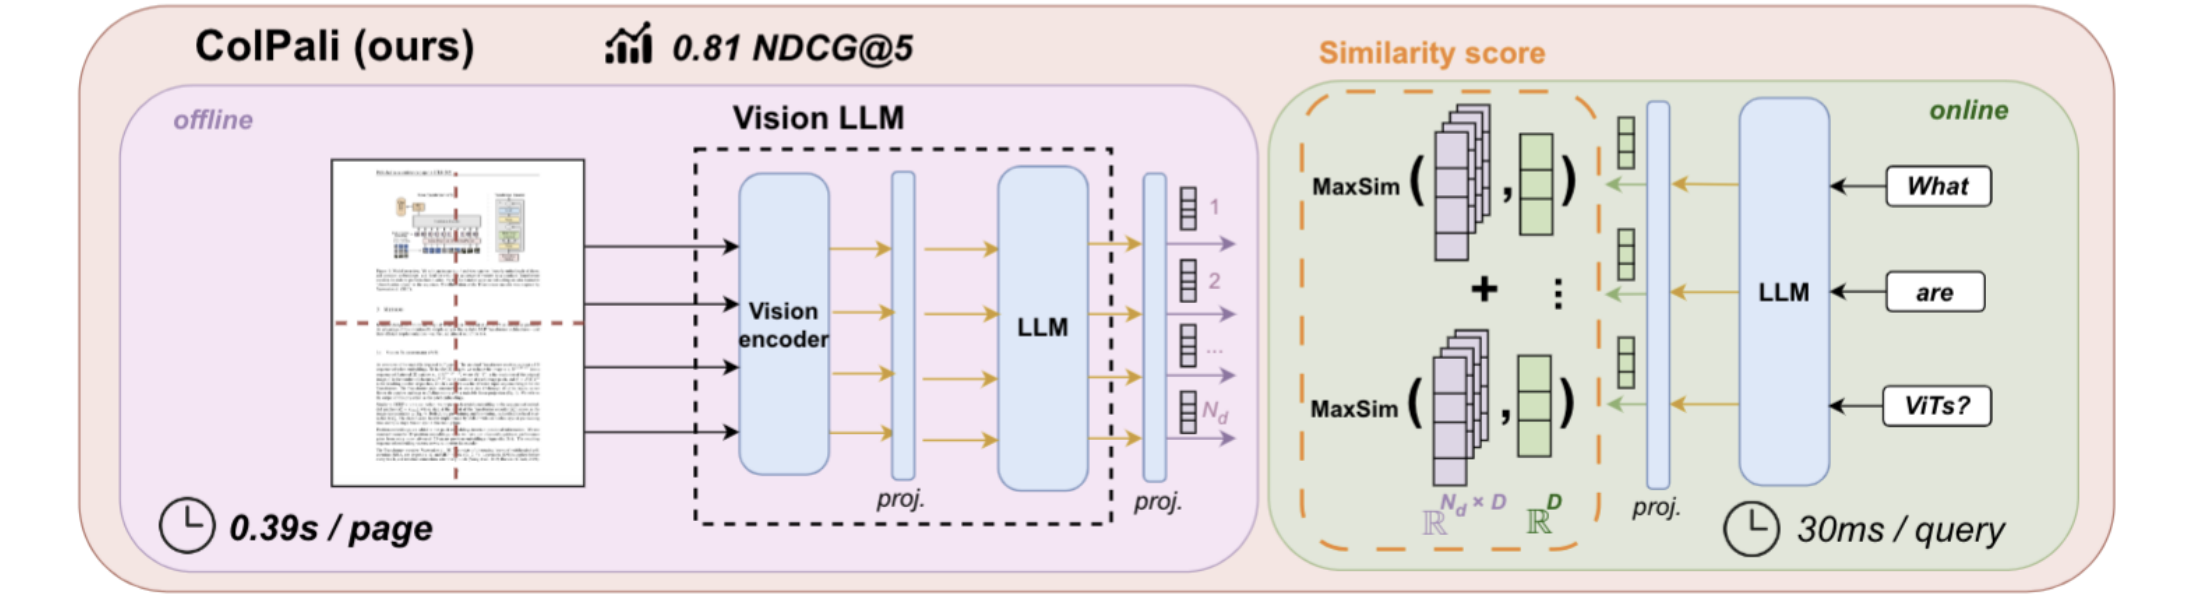

### Let's query our indexed document.

Here the important thing to note is that the query is asking for details that are found on page 25 of the PDF!

In [7]:
# Lets query our index and retrieve the page that has content with the highest similarity to the query

# The Data Centre revenue results are on page 25 - for context!
query = "What are the half year data centre renevue results and the 5 year CAGR for Nvidia data centre revenue?"
results = model.search(query, k=5)

print(f"Search results for '{query}':")
for result in results:
    print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}")

print("Test completed successfully!")

Search results for 'What are the half year data centre renevue results and the 5 year CAGR for Nvidia data centre revenue?':
Doc ID: 0, Page: 25, Score: 25.875
Doc ID: 0, Page: 24, Score: 25.0
Doc ID: 0, Page: 28, Score: 23.75
Doc ID: 0, Page: 32, Score: 23.75
Doc ID: 0, Page: 31, Score: 23.75
Test completed successfully!


### Notice that ColQwen2 is able to retrieve that correct page with the highest similarity!

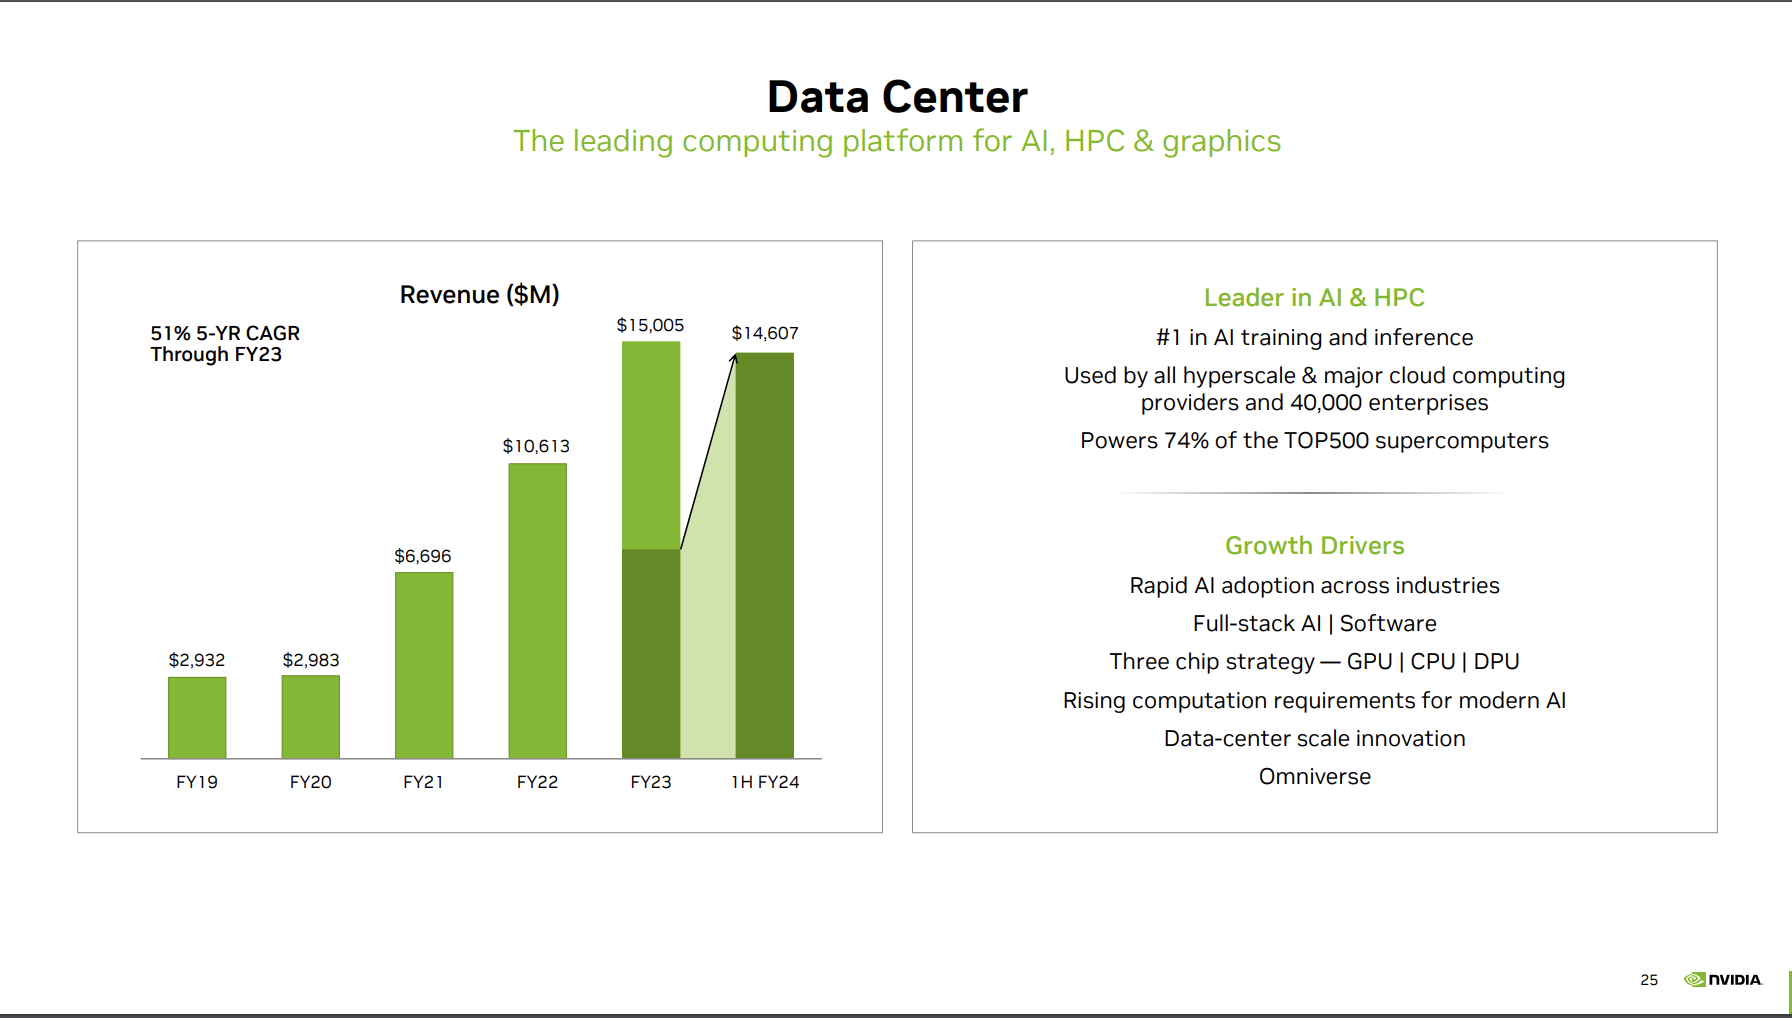

The retrieval step takes about 185 ms.

In [8]:
%%timeit
model.search(query, k=5)

182 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Lets now pass in the retrieved page to the Llama-3.2 90B Vision Model.

This model will read the question: `"What are the half year data centre renevue results and the 5 year CAGR for Nivida data centre revenue?"`

And take in the retrieved page and produce an answer!

You can pass in a URL to the image of the retrieved page or a base64 encoded version of the image.

In [9]:
# Since we stored the collection along with the index we have the base64 images of all PDF pages aswell!
model.search(query, k=1)

[{'doc_id': 0, 'page_num': 25, 'score': 25.875, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAAH0AAABGUCAIAAABQAx/HAAEAAElEQVR4nOzcPUqkWQCGURWrPlOxKANBUQNdgaCJK3Ah7silmAmmGhgYCJoYNyiYWAMlNcE8QWfzQ0/XMH1OcMN737uBZ3WxWKwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAALCysrbsAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA/xUC7gAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEXAHAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIiAOwAAAAAAAAAAAAAAAAAAAAAAAAAAAABABNwBAAAAAAAAAAAAAAAAAAAAAAAAAAAAACLgDgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQAXcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAi4AwAAAAAAAAAAAAAAAAAAAAAAAAAAAABEwB0AAAAAAAAAAAAAAAAAAAAAAAAAAAAAIALuAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAARcAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAiIA7AAAAAAAAAAAAAAAAAAAAAAAAAAAAAEAE3AEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAIuAOAAAAAAAAAAAAAAAAAAAAAAAAAAAAABABdwAAAAAAAAAAAAAAAAAAAAAAAAAAAACACLgDAAAAAAAAAAAAAAAAAAAAAAAAAAAAAETAHQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAu4AAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFwBwAAAAAAAAAAAAAAAAAAAAAAAAAAAACIgDsAAAAAAAAAAAAAAAAAAAAAAAAAAAAAQATcAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAi4A4AAAAAAAAAAAAAAAAAAAAAAAAAA

In [10]:
returned_page = model.search(query, k=1)[0].base64

## We'll use a [Together AI](together.ai) inference endpoint to access the Llama-3.2 90B Vision model

In [11]:
from together import Together
import requests, os
import base64

client = Together(api_key = api_key)

data = {
    "model": "meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
    "max_tokens": 200,
    "messages":[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": query}, #query
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{returned_page}" #retrieved page image
                    }
                }
            ]
        }
    ],
    "stream": False,
    "logprobs": False
}

headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json"
}

response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=data)

In [13]:
print(response.json()['choices'][0]['message']['content'])

The half-year data centre revenue results and 5-year CAGR for Nvidia's data centre revenue are as follows:

*   **Half-Year Data Centre Revenue Results:**
    *   The half-year revenue result is $14,607 million.
*   **5-Year CAGR for Nvidia's Data Centre Revenue:**
    *   The 5-year CAGR is 51%.

These numbers indicate significant growth in Nvidia's data centre revenue over the past five years, with a substantial increase in the first half of the current fiscal year.


Here we can see that the combination of ColQwen2 as a image retriever and Llama-3.2 90B Vision is a powerful duo for multimodal RAG applications specially with PDFs.

Not only was ColQwen2 able to retrieve the correct page that had the right answer on it but then Llama-3.2 90B Vision was also able to find exactly where on the page this answer was, ignoring all the irrelvant details!

Voila!🎉🎉

Learn more about Llama 3.2 Vision in the [docs](https://docs.together.ai/docs/vision-overview) here!